## Compare if we get more information from which columns


In [2]:
from models.ICA_EM import *
from models.dgp import *
from models.metrics import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib, sys
importlib.reload(sys.modules['models.dgp'])
importlib.reload(sys.modules['models.metrics'])
importlib.reload(sys.modules['models.ICA_EM'])
import tqdm
from sklearn.metrics import mean_squared_error as mse

In [3]:
n = 10000
J = 6
I = 5

In [3]:
def percentage_first_column_is_better(treatment_true, treatment_first, treatment_third):
    # requires numpy arrays

    deviation_first = np.abs(treatment_first - treatment_true)
    deviation_third = np.abs(treatment_third - treatment_true)
    return np.sum(deviation_first < deviation_third)/len(deviation_first)

    

### No init CausalVarEM



In [5]:
true_treatment = []
est_treatment_col = []
est_confounder_col = []
data = dgp(noise_dict= {"loc" : 0, "scale" : 0}, prior= {"loc" : 0, "scale" : 1/np.sqrt(2)})
for i in tqdm.tqdm(range(200)):
    data.generate_data(n,I, J, random_state=i)
    est = CausalVarEM(update_sigma=False, true_A=None, max_iter = 100, random_seed= i)
    true_treatment.append(data.treatment_effect)
    est.fit(data.data_observed,J, noise_params= {"mean" : 0, "std" : 1}, progress_bar=False)
    est_treatment_col.append(est.A[-1,J-2])
    est_confounder_col.append(est.A[-1,0]) 
df = pd.DataFrame(
    {
        "true_treatment": true_treatment,
        "est_treatment_treatment_col": est_treatment_col,
        "est_treatment_confounder_col": est_confounder_col
    }
)
df.to_csv("results/new_order_column_comp_CausalVarEM_no_A.csv", index=False)

100%|██████████| 200/200 [1:15:17<00:00, 22.59s/it]


Text(0.5, 0, 'true treatment')

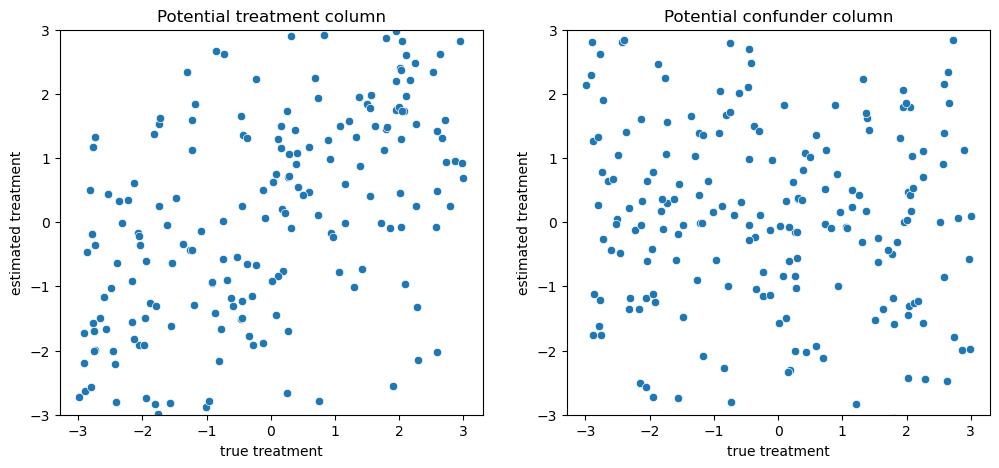

In [4]:
df = pd.read_csv("results/new_order_column_comp_CausalVarEM_no_A.csv")
fig, ax = plt.subplots(1,2, figsize = (12,5))
sns.scatterplot(x = "true_treatment", y = "est_treatment_treatment_col", data = df,ax = ax[0])
ax[0].set_title("Potential treatment column")

ax[0].set_ylabel("estimated treatment")
ax[0].set_xlabel("true treatment")
ax[0].set_ylim(-3,3)


sns.scatterplot(x = "true_treatment", y = "est_treatment_confounder_col", data = df,ax = ax[1])
ax[1].set_title("Potential confunder column")
ax[1].set_ylabel("estimated treatment")
ax[1].set_ylim(-3,3)


ax[1].set_xlabel("true treatment")


In [7]:
# root mse
est_treatment_col = df.est_treatment_treatment_col
est_confounder_col = df.est_treatment_confounder_col
print("Root MSE first column", np.sqrt(mse(df.true_treatment, est_treatment_col)))
print("Root MSE third column unnormed", np.sqrt(mse(df.true_treatment, est_confounder_col)))
# mean absolute error
print("Mean absolute error first column", np.mean(np.abs(df.true_treatment -est_treatment_col)))
print("Mean absolute error first column", np.mean(np.abs(df.true_treatment- est_confounder_col)))
# std of the error
print("Std of the error first column", np.std(df.true_treatment -est_treatment_col))
print("Std of the error third column unnormed", np.std(df.true_treatment -est_confounder_col))

print("Percentage first column is better then unormalized other", percentage_first_column_is_better(df.true_treatment, est_treatment_col, -est_confounder_col))


Root MSE first column 1.6661044403017737
Root MSE third column unnormed 2.4039941329187737
Mean absolute error first column 1.2884473275360522
Mean absolute error first column 1.9312602407391564
Std of the error first column 1.658624805790717
Std of the error third column unnormed 2.3970745978390227
Percentage first column is better then unormalized other 0.61


## True A CausalVarEM




In [84]:
true_treatment = []
est_treatment_col = []
est_confounder_col = []

data = dgp(noise_dict= {"loc" : 0, "scale" : 0}, prior= {"loc" : 0, "scale" : 1/np.sqrt(2)})
for i in tqdm.tqdm(range(100)):
    data.generate_data(n,I, J, random_state=i)
    est = CausalVarEM(update_sigma=False, true_A=data.mixing_matrix_observed, max_iter = 100,
                      random_seed= i)
    true_treatment.append(data.treatment_effect)
    est.fit(data.data_observed,J, noise_params= {"mean" : 0, "std" : 1}, progress_bar=False)
    est_treatment_col.append(est.A[-1,J-2])
    est_confounder_col.append(est.A[-1, 0])   

df = pd.DataFrame(
    {
        "true_treatment": true_treatment,
        "est_treatment_second_last": est_treatment_col,
        "est_treatment_third_unnormed": est_confounder_col
    }
)
df.to_csv("results/new_order_column_comp_CausalVarEM_true_A.csv", index=False)
    


100%|██████████| 100/100 [37:01<00:00, 22.22s/it]


Text(0.5, 0, 'true treatment')

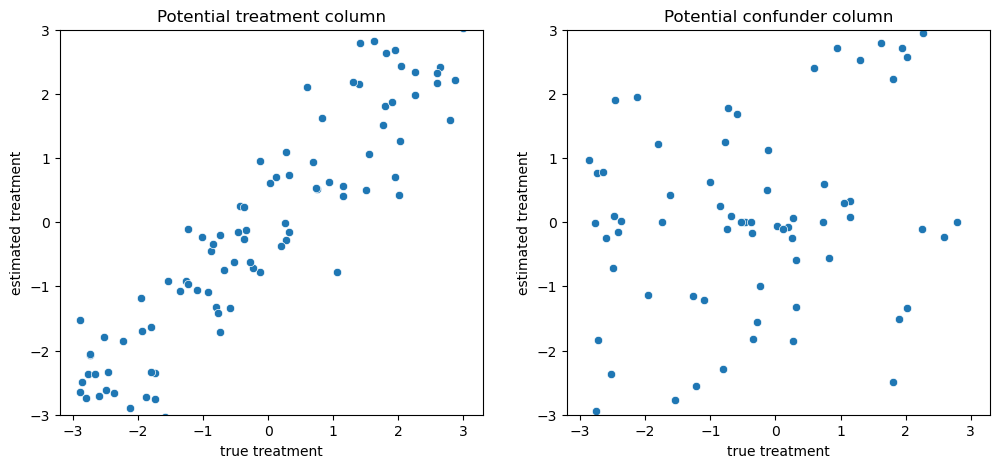

In [8]:
df = pd.read_csv("results/new_order_column_comp_CausalVarEM_true_A.csv")
fig, ax = plt.subplots(1,2, figsize = (12,5))
sns.scatterplot(x = "true_treatment", y = "est_treatment_second_last", data = df,ax = ax[0])
ax[0].set_title("Potential treatment column")

ax[0].set_ylabel("estimated treatment")
ax[0].set_xlabel("true treatment")
ax[0].set_ylim(-3,3)


sns.scatterplot(x = "true_treatment", y = "est_treatment_third_unnormed", data = df,ax = ax[1])
ax[1].set_title("Potential confunder column")
ax[1].set_ylabel("estimated treatment")
ax[1].set_ylim(-3,3)


ax[1].set_xlabel("true treatment")



In [10]:
# root mse
print("Root MSE first column", np.sqrt(mse(df.true_treatment, df.est_treatment_second_last)))
print("Root MSE third column unnormed", np.sqrt(mse(df.true_treatment, df.est_treatment_third_unnormed)))
# mean absolute error
print("Mean absolute error first column", np.mean(np.abs(df.true_treatment -df.est_treatment_second_last)))
print("Mean absolute error first column", np.mean(np.abs(df.true_treatment- df.est_treatment_third_unnormed)))
# std of the error
print("Std of the error first column", np.std(df.true_treatment -df.est_treatment_second_last))
print("Std of the error third column unnormed", np.std(df.true_treatment -df.est_treatment_third_unnormed))

print("Percentage first column is better then unormalized other", percentage_first_column_is_better(df.true_treatment, df.est_treatment_second_last,-df.est_treatment_third_unnormed))


Root MSE first column 0.7279652822850973
Root MSE third column unnormed 3.7911255630904988
Mean absolute error first column 0.6032654032465129
Mean absolute error first column 2.726643131964794
Std of the error first column 0.7278576974803198
Std of the error third column unnormed 3.784352533690085
Percentage first column is better then unormalized other 0.83
